## Improving Sentiment Model

This notebook uses data taken from the github repository by Charles Malfosse https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis

## Tasks

- Clean & lemmatize training data

------

### Import Pandas and set options

In [80]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

### Read the data

In [81]:
players = pd.read_csv("one-betsentiment-EN-tweets-sentiment-players.csv", engine="python")

In [82]:
teams = pd.read_csv("betsentiment-EN-tweets-sentiment-teams.csv", engine="python")

### Inspect the data

### Drop Columns:

- 'tweet_date_created'
- 'tweet_id'
- 'language'

In [84]:
players = players.drop(['tweet_date_created', 'tweet_id', 'language'], axis=1)

In [85]:
teams = teams.drop(['tweet_date_created', 'tweet_id', 'language'], axis=1)

### Concat two dataframes

In [86]:
frames = [players, teams]

In [87]:
df = pd.concat(frames)

### Visualise Spread of Sentiments

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
plot_size = plt.rcParams["figure.figsize"] 

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size
fig = plt.figure()

<Figure size 576x432 with 0 Axes>

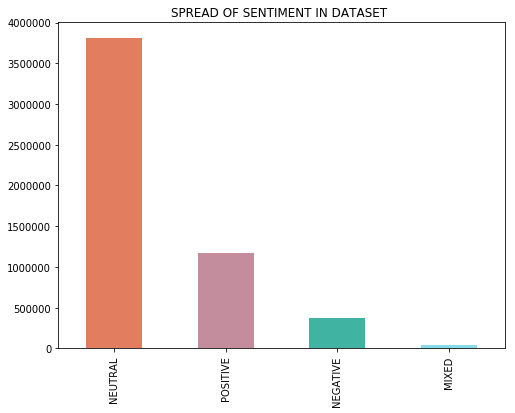

In [92]:
df.sentiment.value_counts().plot(kind='bar', colors=["#e27d60", "#c38d9e", "#41b3a3", "#85dceb"], title="SPREAD OF SENTIMENT IN DATASET ", fontsize=10)

##### Potential issue with spread of sentiment in dataset

The imbalance between types of sentiment in this dataset could be problematic for training my model and result in different accuracies for each sentiment. 

### Cleaning the Data

#### Removing '@handles' 

In [93]:
import re

In [100]:
# Function to remove twitter handles using regex
def remove_handles(x):
    return re.sub("@[^\s]+","", str(x))

In [101]:
# Apply function to 'tweet_text' column
df['no_handles'] = df['tweet_text'].apply(remove_handles)

#### Removing '#' signs

In [103]:
# Function to remove just # sign from 'no_handles' column
def remove_hash(x):
    return re.sub("#","", str(x))

In [104]:
# Apply function to 'no_handles' column
df['no_hash'] = df['no_handles'].apply(remove_hash)

#### Removing � signs

In [105]:
# Function to remove just # sign from 'no_hash' column
def remove_question(x):
    return re.sub("�","", str(x))

In [106]:
# Apply function to 'no_hash' column
df['no_question'] = df['no_hash'].apply(remove_question)

#### Drop Old Columns

In [107]:
df = df.drop(['no_hash', 'no_handles', 'tweet_text'], axis=1)

#### Remove URLs

In [112]:
# Function to remove URLs from 'no_question' column
def remove_url(x):
    return re.sub("http[^\s]+","", str(x))

In [115]:
df['no_url'] = df['no_question'].apply(remove_url)

#### Replace /n

In [123]:
# Function to replace /n from 'no_url' column
def replace_newline(x):
    return re.sub("\n"," ", str(x))

In [125]:
df['clean'] = df['no_url'].apply(replace_newline)

#### Drop more columns

In [127]:
df = df.drop(['no_question', 'no_url'], axis=1)

In [157]:
df.head()

,sentiment,sentiment_score,clean
0,NEUTRAL,"{""Neutral"":0.795609652996063232421875,""Negative"":0.0004731244407594203948974609375,""Positive"":0.2020459473133087158203125,""Mixed"":0.001871291664429008960723876953125}",I vote for ManoftheMatch URUPOR. Tap below to vote now!
1,NEUTRAL,"{""Neutral"":0.97318065166473388671875,""Negative"":0.013416674919426441192626953125,""Positive"":0.00890920497477054595947265625,""Mixed"":0.0044934828765690326690673828125}",When is your first match? Didn't see you today :/
2,NEUTRAL,"{""Neutral"":0.9692952632904052734375,""Negative"":0.0076706311665475368499755859375,""Positive"":0.01771019212901592254638671875,""Mixed"":0.0053239776752889156341552734375}",You never know what you had till its gone. GraciasCristiano
3,POSITIVE,"{""Neutral"":0.257103621959686279296875,""Negative"":0.001556603354401886463165283203125,""Positive"":0.727192461490631103515625,""Mixed"":0.01414733193814754486083984375}",You look good man I'd appreciate if I got your Jersey here in Africa ??
4,NEUTRAL,"{""Neutral"":0.584071457386016845703125,""Negative"":0.02674569748342037200927734375,""Positive"":0.375729739665985107421875,""Mixed"":0.01345316134393215179443359375}",Expect loads of excuses after tonights game


-----

### Create equal balance of positive, negative & neutral

> This method removes lots of neutral and positive tweets
- I want to end up with 350,000 of each 
- Another good option would be upsampling but would risk the dataset being too big?


#### Positive

In [158]:
positive = df[df['sentiment'] == 'POSITIVE']

In [159]:
len(positive)

1167858

In [166]:
positive_sample = positive.sample(n=350000, random_state=123)

#### Negative

In [162]:
negative = df[df['sentiment'] == 'NEGATIVE']

In [163]:
len(negative)

373854

In [168]:
negative_sample =  negative.sample(n=350000, random_state=123)

#### Neutral

In [164]:
neutral = df[df['sentiment'] == 'NEUTRAL']

In [165]:
len(neutral)

3812427

In [169]:
neutral_sample =  neutral.sample(n=350000, random_state=123)

#### Concat three sample datasets

In [170]:
samples = [negative_sample, positive_sample, neutral_sample]

In [171]:
df_train = pd.concat(samples)

#### Shuffle Dataset

In [174]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

-----

### Visualise spread after sampling

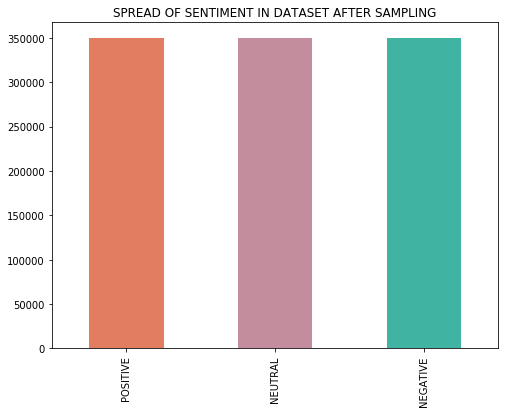

In [178]:
df_train.sentiment.value_counts().plot(kind='bar', colors=["#e27d60", "#c38d9e", "#41b3a3", "#85dceb"], title="SPREAD OF SENTIMENT IN DATASET AFTER SAMPLING", fontsize=10)

------

### Lemmatize & Remove Stopwords

In [187]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

#### Import MyStopWords

In [192]:
import mystopwords

In [195]:
stop_words = mystopwords.stopwords()

#### Define Function to lemmatize & remove stopwords from clean text 

In [198]:
def stopwords_lemmatize(input):
    return " ".join([WordNetLemmatizer().lemmatize(word) for word in word_tokenize(input) if word not in stop_words])

#### Apply Function to training data

In [207]:
df_train['clean'] = df_train['clean'].apply(stopwords_lemmatize)

------


### Export Training Data as CSV

In [209]:
df_train.to_csv(r'football_sentiment_training_data.csv', index = False)